In [2]:
import os
import sys
import ast
import cv2
import json
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.append('../')
from utils import normalize_image, plot_image, plot_images

### Poke into COCO data and label format

In [42]:
def plot_image(img, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.xticks([])
    # plt.yticks([])
    plt.show()

In [72]:
# json_file = '/data/jupiter/li.yu/data/fiftyone/coco-2017/validation/labels.json'
# data_dir = '/data/jupiter/li.yu/data/fiftyone/coco-2017/validation/data'
data_dir = '/data/jupiter/li.yu/data/fiftyone/brt2000/data'
json_file = '/data/jupiter/li.yu/data/fiftyone/brt2000/labels.json'
with open(json_file, 'r') as f:
    data = json.load(f)
len(data), data.keys()

(3, dict_keys(['images', 'annotations', 'categories']))

In [73]:
# remove segmentation field
for anno in data['annotations']:
    del anno['segmentation']

KeyError: 'segmentation'

In [62]:
data['categories']

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [74]:
len(data['images']), len(data['annotations'])

(2000, 1517)

In [64]:
print(data['images'][1])
print(data['annotations'][1])

{'license': 1, 'file_name': '000000057597.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000057597.jpg', 'height': 426, 'width': 640, 'date_captured': '2013-11-22 02:36:28', 'flickr_url': 'http://farm7.staticflickr.com/6239/6258453198_b6ee9e6d6f_z.jpg', 'id': 57597}
{'area': 426.9120499999995, 'iscrowd': 0, 'image_id': 45596, 'bbox': [161.52, 507.18, 46.45, 19.16], 'category_id': 2, 'id': 124742}


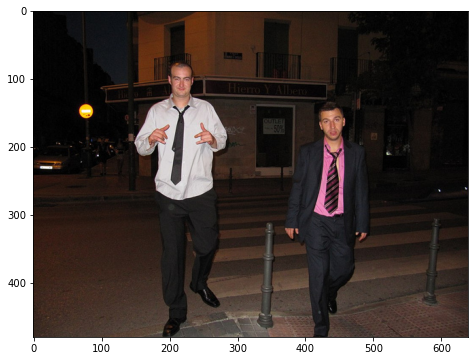

{'area': 1310.1337500000016, 'iscrowd': 0, 'image_id': 25393, 'bbox': [430.38, 203.87, 22.65, 96.0], 'category_id': 32, 'id': 294986}
{'area': 1349.66955, 'iscrowd': 0, 'image_id': 25393, 'bbox': [202.04, 139.47, 28.31, 119.08], 'category_id': 32, 'id': 298549}
{'area': 29891.466399999994, 'iscrowd': 0, 'image_id': 25393, 'bbox': [148.95, 73.51, 137.28, 401.06], 'category_id': 1, 'id': 515072}
{'area': 1084.8717000000004, 'iscrowd': 0, 'image_id': 25393, 'bbox': [0.0, 200.91, 45.53, 35.11], 'category_id': 3, 'id': 1770898}
{'area': 1292.1432, 'iscrowd': 0, 'image_id': 25393, 'bbox': [19.79, 198.03, 49.92, 42.21], 'category_id': 3, 'id': 1774602}
{'area': 589.9693, 'iscrowd': 0, 'image_id': 25393, 'bbox': [68.65, 199.54, 29.52, 35.58], 'category_id': 3, 'id': 2039050}
{'area': 578.1044, 'iscrowd': 0, 'image_id': 25393, 'bbox': [96.54, 195.18, 28.71, 28.18], 'category_id': 3, 'id': 2046008}
{'area': 714.4890499999996, 'iscrowd': 0, 'image_id': 25393, 'bbox': [90.1, 184.16, 25.51, 60.94],

In [66]:
i = 9
image_path = os.path.join(data_dir, data['images'][i]['file_name'])
image = cv2.imread(image_path)
plot_image(image)

anns = [ann for ann in data['annotations'] if ann['image_id'] == data['images'][i]['id']]
for ann in anns:
    print(ann)

### Create COCO-like BRT dataset

In [ ]:
def convert_label_column(row):
    row['Humans'] = row["label_counts"].get("Humans", 0)
    row['Vehicles'] = row["label_counts"].get("Tractors or Vehicles", 0)
    row['Dust'] = row["label_counts"].get("Heavy Dust", 0)
    return row

def get_object_location(object_mask):
    rows, cols = np.where(object_mask)
    return np.min(rows), np.max(rows), np.min(cols), np.max(cols)

In [9]:
root_dir = '/data2/jupiter/datasets/Jupiter_train_v6_1_v2'
csv = '/data/jupiter/li.yu/data/Jupiter_train_v6_1/epoch0_5_30_focal05_master_annotations.csv'
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
df = pd.read_csv(csv, converters=converters)
print(df.shape)
# get human and vehicle counts in images
df = df.apply(lambda row: convert_label_column(row), axis=1)
print(df.shape)

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (6,7,39,223,225,227,230,247,251,254,267,308,324,327,337,338,346,354,370,371,373,376,377) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(317956, 434)

In [40]:
#  'is_standing_human',
#  'is_laying_down_human',
#  'is_multi_human',
#  'occluded_humans',

In [45]:
# sort out subsets to save
human_df = df[(df.Humans > 100) & (df.Humans < 50000) & (df.is_multi_human != True) & (df.occluded_humans != True)]
vehicle_df = df[(df.Vehicles > 100) & (df.Vehicles < 80000)]
dust_df = df[(df.Dust > 100) & (df.Dust < 50000) & (df.is_multi_human != True) & (df.occluded_humans != True)]
# ioi_df = pd.concat([human_df, vehicle_df, dust_df], ignore_index=True)  # image of interest
ioi_df = pd.concat([human_df, dust_df], ignore_index=True).drop_duplicates(subset='id')  # image of interest
ofs_df = df[(df.Humans == 0) & (df.Vehicles == 0)]  # out of scope
# print(human_df.shape, vehicle_df.shape, dust_df.shape)
print(human_df.shape, dust_df.shape)
print(ioi_df.shape, ofs_df.shape)

(38299, 437) (12407, 437)
(50485, 437) (240883, 437)


In [75]:
ioi_sub_df = ioi_df.sample(n=50000)
# ofs_sub_df = ofs_df.sample(n=100)
# tt_df = pd.concat([ioi_sub_df, ofs_sub_df], ignore_index=True).drop_duplicates(subset='id')
tt_df = ioi_sub_df
print(tt_df.shape)

(50000, 437)


In [ ]:
{'license': 1,
 'file_name': '000000057597.jpg',
 'coco_url': 'http://images.cocodataset.org/val2017/000000057597.jpg',
 'height': 426,
 'width': 640,
 'date_captured': '2013-11-22 02:36:28',
 'flickr_url': 'http://farm7.staticflickr.com/6239/6258453198_b6ee9e6d6f_z.jpg',
 'id': 57597},
{'area': 1310.1337500000016, 'iscrowd': 0, 'image_id': 25393, 'bbox': [430.38, 203.87, 22.65, 96.0], 'category_id': 32, 'id': 294986}

In [76]:
# save image and label json
save_dir = '/data/jupiter/li.yu/data/fiftyone/brt50000'
save_data_dir = os.path.join(save_dir, 'data')
save_json_dir = os.path.join(save_dir, 'labels.json')
os.makedirs(save_data_dir, exist_ok=True)

brt_data = {'images':[], 'annotations':[], 'categories':data['categories']}
for _,row in tt_df.iterrows():
    # save image
    data_path = os.path.join(root_dir, row.stereo_pipeline_npz_save_path)
    stereo_data = np.load(data_path)
    img = stereo_data['left']
    img_norm = normalize_image(img, row.hdr_mode)
    img_uint8 = cv2.cvtColor((img_norm*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(save_data_dir, row.id+'.png'), img_uint8)
    brt_data['images'].append({'file_name': row.id+'.png', 'height': 512, 'width': 1024, 'id': row.id})

    # save label
    label_path = os.path.join(root_dir, row.rectified_label_save_path)
    lbl = np.load(label_path)['left'][:, :, 0]  # convert HW1 to HW
    labels, counts = np.unique(lbl, return_counts=True)
    label_map = row.label_map
    label_strs = [label_map[str(i)] for i in labels if i != 0]
    for i,c in zip(labels, counts):
        if i == 0:
            continue
        if label_map[str(i)] == 'Humans':
            y1, y2, x1, x2 = get_object_location(lbl == i)
            bbox = [x1, y1, x2-x1+1, y2-y1+1]
            brt_data['annotations'].append({'area': int(c), 'image_id': row.id, 'bbox': [int(i) for i in bbox], 
                                            'category_id': 1, 'id': row.annotation_pixelwise_0__id})

with open(save_json_dir, "w") as f:
    f.write(json.dumps(brt_data, indent=2))

In [77]:
len(brt_data['images']), len(brt_data['annotations'])

(50000, 37949)

### Check GSAM results

In [3]:
data_dir = '/data/jupiter/li.yu/data/Jupiter_rev1_train_1784_human_sequences'
df = pd.read_csv(os.path.join(data_dir, 'master_annotations.csv'))
print(df.shape)

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (45,48,56,57,58,59,61,62,63,64,65,66,67,68,69,70,71,72,74,75,76,77,79,80,82,83,85,86,87,88,89,90,92,93,94,95,97,98,100,101,103,104,105,106,107,108,110,111,112,113,115,116,118,119,121,122,123,124,125,126,128,129,130,131,133,134,135,136,137,139,140,141,142,143,144,146,147,148,149,151,152,153,154,155,157,158,159,160,161,162,207,210,218,219,220,221,223,224,225,226,227,228,229,230,231,232,236,237,238,239,241,242,244,245,247,248,249,250,254,255,256,257,259,260,262,263,265,266,267,268,272,273,274,275,277,278,280,281,283,284,285,286,290,291,292,293,295,296,297,298,299,301,302,303,304,305,306,333,336,351,354,416,417,418,419,421,422,424,425,427,428,429,430,431,432,434,435,436,437,439,440,442,443,445,446,447,448,449,450,452,453,454,455,457,458,459,460,461,463,464,465,466,467,468,470,471,472,473,475,476,477,478,479,481,482,483,484,485,486,488,489,490,491,493,494,495,

(54729, 702)


In [9]:
pred_csv = '/data/jupiter/li.yu/exps/driveable_terrain_model/v511rd_7cls_ft_dustaugonhuman_0908/Jupiter_rev1_train_1784_human_sequences/output.csv'
pred_df = pd.read_csv(pred_csv)
print(pred_df.shape)
pred_df.groupby('human_state').count()

(54729, 11)


,unique_id,id,camera_location,operation_time,special_notes,jdb_s3_path,state,vehicle_state,min_pixels_threshold,features
human_state,,,,,,,,,,
false_positive,36404,36404,36404,30129,14446,14553,36404,0,36404,36404
true_negative,18325,18325,18325,16229,9122,9207,18325,0,18325,18325


In [10]:
csv = f'{data_dir}/gsam_results_rectified/rectified_left/summary.csv'
gsam_df = pd.read_csv(csv)
print(gsam_df.shape)
gsam_df.groupby('predicted_humans1').count()

(54484, 4)


,npz,predicted_humans2,id
predicted_humans1,,,
False,17058,17058,17058
True,37426,37426,37426


In [13]:
pred_ids = pred_df[pred_df.human_state == 'false_positive'].id.to_list()
gsam_ids = gsam_df[gsam_df.predicted_humans1 == True].id.to_list()
print(len(pred_ids), len(gsam_ids), len(set(pred_ids).intersection(gsam_ids)))


36404 37426 31123


(1, 702)
61c4951f69d1eb95c2fdf1cf


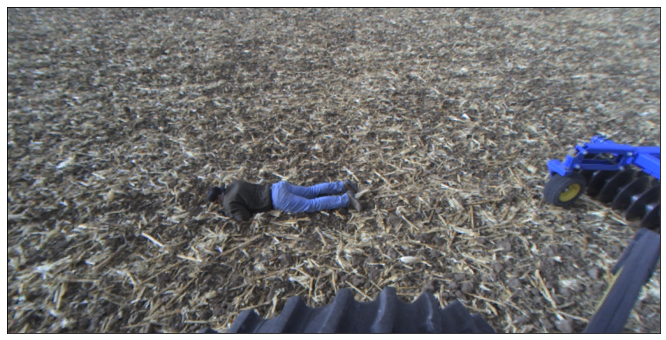

In [4]:
image_id = '61c4951f69d1eb95c2fdf1cf'
sample_df = df[df.image_id == image_id]
# sample_df = df[df.camera_location == 'rear-left'].sample(5)
# sample_df = df[df.general_state == 'true_negative']
# sample_df = df[(~df.id.isin(pred_ids)) & (df.id.isin(gsam_ids))]
print(sample_df.shape)
sample_df = sample_df.sample(1)
for i, row in sample_df.iterrows():
    data_path = os.path.join(data_dir, 'processed/images', row.id, 'stereo_output.npz')
    data = np.load(data_path)
    img = data['left']
    img = normalize_image(img, row.hdr_mode)

    if 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(data_dir, row.rectified_label_save_path)
        lbl = np.load(label_path)['left']
    #     if np.any(lbl == 21):
    #     if np.all(lbl != 11):

        print(row.image_id, np.unique(lbl))
        plt.figure(figsize=(12, 6))
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.figure(figsize=(12, 6))
        plt.imshow(lbl==8)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        print(row.image_id)
        plt.figure(figsize=(12, 6))
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

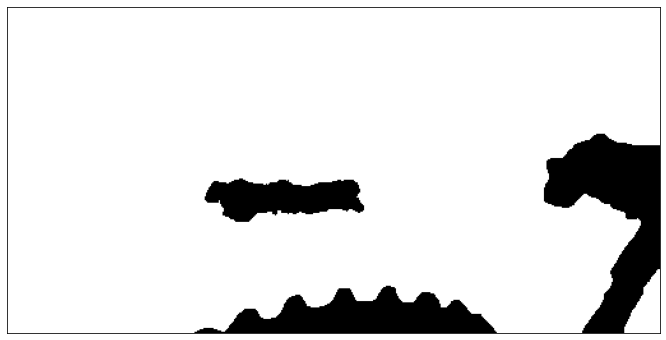

In [11]:
label = cv2.imread('/home/li.yu/code/scripts/61c4951f69d1eb95c2fdf1cf.png')
label.shape
# plot_image(label)
plot_image((label == 0)*255)